## Dacon 11회 에너지 빅데이터 활용 데이터 사이언스 콘테스트
## Don't_overfit
## 2019년 10월 28일 (제출날짜)

## 1. 라이브러리 및 데이터
## Library & Data

In [1]:
import pandas as pd # 데이터 분석
import numpy as np # 행렬 연산
import os # 경로 설정
import tqdm # 진행상황 파악
import datetime # 날짜타입 사용
import random # 시드 제어
from collections import defaultdict # dict 자료구조

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold # 일반화

import lightgbm as lgb

# install
!pip install workalendar
from workalendar.asia import SouthKorea # 한국의 공휴일, version : 1.1.1

path = '../data/'
os.chdir(path)

#사용한 데이터 불러오기
test = pd.read_csv("test.csv") # 대회 데이터
sub = pd.read_csv("submission.csv") # 대회 데이터
weather = pd.read_csv("weather_hour.csv", encoding='cp949') # 대회 데이터

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 163kB 9.0MB/s 
     |████████████████████████████████| 225kB 43.3MB/s 
     |████████████████████████████████| 16.0MB 155kB/s 
  Created wheel for pyCalverter: filename=pyCalverter-1.6.1-cp36-none-any.whl size=4200 sha256=5574a5cb497f79a311155322935c8ee50b01752f17dc40659d9241900a509266
  Stored in directory: /root/.cache/pip/wheels/77/4d/86/db4ff4eca6178dbbd5a365d095f97f6021e2a48f09908be79c
  Created wheel for skyfield: 

## 2. 데이터 전처리
## Data Cleansing & Pre-Processing

In [0]:
# 시드를 고정하는 함수
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

In [0]:
# 온도데이터는 일시와 기온만 사용
weather['일시'] = pd.to_datetime(weather['일시'])
weather = weather.iloc[:, 1:3]
weather.columns = ['Time', 'temp']

# 16, 17, 18년 공휴일
ㅇholidays = pd.concat([pd.Series(np.array(SouthKorea().holidays(2018))[:, 0]), pd.Series(np.array(SouthKorea().holidays(2017))[:, 0]), pd.Series(np.array(SouthKorea().holidays(2016))[:, 0])]).reset_index(drop=True)

#### 변수
- Time으로부터 생성하는 변수 : month, week, weekday, day, hour
- weekend와 holiday를 이용하여, 휴일을 정의
- 직전주차에 사용한 전력량의 std와 mean을 변수로 사용(only hour predict) -> 모델에 추세에 대한 정보를 부여하는 목적
- target 변수의 outlier를 제거하기 위해 평균을 기준으로 3sigma 외의 값들 clipping


#### Case
- include temp and hour predict
- exclude temp and hour predict
- exclude temp and day, month predict

In [0]:
def merge(train, col, hour=True, use_temp=True):
    temp = train[['Time', col]].rename(columns={col:'target'})
    temp['Time'] = pd.to_datetime(temp['Time'])
    temp = temp[temp['Time']>='2017-11-23'].reset_index(drop=True)
    temp = temp.loc[temp.index[temp['target'].astype(str)!='nan'][0]:].reset_index(drop=True)

    temp['Time'] = pd.to_datetime(temp['Time'])
    temp['month'] = temp['Time'].dt.month
    temp['week'] = temp['Time'].dt.week
    temp['weekday'] = temp['Time'].dt.weekday
    temp['day'] = temp['Time'].dt.day
    temp['hour'] = temp['Time'].dt.hour
    temp['holiday'] = temp['Time'].dt.date.isin(holidays).astype(int)
    temp['weekend'] = temp['weekday'].map({0:0, 1:0, 2:0, 3:0, 4:0, 5:1, 6:1})
    temp['is_holiday'] = (temp['weekend'] + temp['holiday']).map({0:0, 1:1, 2:1})
    temp['date'] = pd.to_datetime(temp['Time'].dt.date)
    temp['tomorrow'] = pd.to_datetime(temp['date']) + datetime.timedelta(days=1)

    for i in range(24):
        temp.loc[temp['hour']==i, 'target'] = temp.loc[temp['hour']==i, 'target'].clip(0, temp.loc[temp['hour']==i, 'target'].mean() + 3*temp.loc[temp['hour']==i, 'target'].std())

    if hour:
        temp2 = pd.DataFrame(pd.date_range('20180701', '20181201', freq='h'), columns=['Time']).iloc[:24, :]
    else:
        temp2 = pd.DataFrame(pd.date_range('20180701', '20181201', freq='h'), columns=['Time']).iloc[:-1]
    temp2['Time'] = pd.to_datetime(temp2['Time'])
    temp2['month'] = temp2['Time'].dt.month
    temp2['week'] = temp2['Time'].dt.week
    temp2['weekday'] = temp2['Time'].dt.weekday
    temp2['day'] = temp2['Time'].dt.day
    temp2['hour'] = temp2['Time'].dt.hour
    temp2['holiday'] = temp2['Time'].dt.date.isin(holidays).astype(int)
    temp2['weekend'] = temp2['weekday'].map({0:0, 1:0, 2:0, 3:0, 4:0, 5:1, 6:1})
    temp2['is_holiday'] = (temp2['weekend'] + temp2['holiday']).map({0:0, 1:1, 2:1})
    temp2['date'] = pd.to_datetime(temp2['Time'].dt.date)
    temp2['tomorrow'] = pd.to_datetime(temp2['date']) + datetime.timedelta(days=1)


    if hour:
        temp['next_week'] = temp['week']+1
        temp2['next_week'] = temp2['week']+1

        temp_dict = temp.groupby('next_week')['target'].mean()
        temp['next_week_mean'] = temp['week'].map(temp_dict)
        temp2['next_week_mean'] = temp2['week'].map(temp_dict)
        temp_dict = temp.groupby('next_week')['target'].std()
        temp['next_week_std'] = temp['week'].map(temp_dict)
        temp2['next_week_std'] = temp2['week'].map(temp_dict)

        if use_temp:
            temp = pd.merge(temp, weather, how='left', on='Time')
            temp2 = pd.merge(temp2, weather, how='left', on='Time')

        return temp.dropna().reset_index(drop=True), temp2
    else:
        return temp.dropna().reset_index(drop=True), temp2

## 3. 탐색적 자료분석
## Exploratory Data Analysis
#### Time 별로 전력사용량의 변화를 주로 관찰

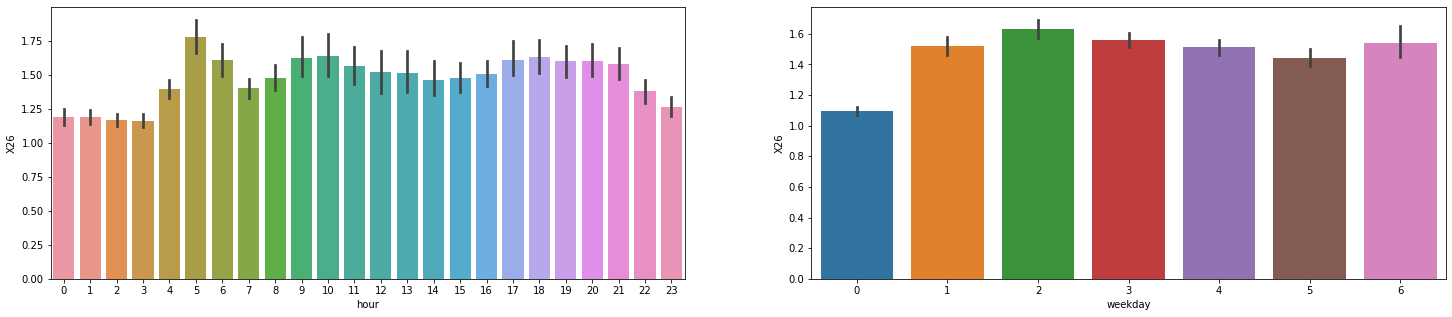

In [19]:
plt.subplots(1, 2, figsize=(25, 5))

plt.subplot(1, 2, 1)
temp_df = test[['Time', 'X26']].dropna()
temp_df['hour'] = pd.to_datetime(temp_df['Time']).dt.hour
sns.barplot(x='hour', y='X26', data=temp_df)

plt.subplot(1, 2, 2)
temp_df = test[['Time', 'X26']].dropna()
temp_df['weekday'] = pd.to_datetime(temp_df['Time']).dt.weekday
sns.barplot(x='weekday', y='X26', data=temp_df)
plt.show()

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling
- 각각의 모델을 만듬으로서 총 200개의 모델 생성
- 베이스모델은 xgboost로 시작
- 속도가 느렸기 때문에, lightgbm으로 변환(성능의 상승) -> xgboost의 경우 overfit의 문제가 있었을 것이라 추정
- kfold, loocv, validation subset 구축 등의 모든 방법이 cv==lb가 맞지 않는 경우 발생
- LB를 기준으로 파라미터 조절을 수행
- 보다 robust한 모델을 구축하기 위해, smape metrics 에서 weight가 강한 hour 예측 모델은 온도 포함/온도 미포함 결과를 앙상블하고 시드앙상블 수행
- 결론적으로 시드앙상블을 안한 모델이 private score가 좋았습니다.

In [0]:
submit_dict = defaultdict()
lgb_params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metric':'rmse',
        'n_jobs':-1,
        'learning_rate':0.03,
        'num_leaves': 2**9,
        'max_depth':-1,
        'tree_learner':'serial',
        'min_child_weight':5, 
        'subsample':0.7,
        'reg_alpha':0.2,
        'reg_lambda':0.2,
        'verbose':-1,
        'seed': 0
    }

for idx in tqdm.tqdm_notebook(list(range(200))):
    hours=True
    using_temp=True
    train_df, test_df = merge(test, sub['meter_id'][idx], hour=hours, use_temp=using_temp)
    glo_pred1 = np.zeros(len(test_df))
    
    for SEED in [42, 43, 44, 45, 46]:
        lgb_params['seed'] = SEED
        pred1 = np.zeros(len(test_df))
        
        feature = [i for i in train_df.columns if i not in ['Time', 'target', 'holiday', 'weekend', 'date', 'tomorrow', 'next_week']]
        kf = KFold(n_splits=5, random_state=SEED, shuffle=True)

        for trn_idx, val_idx in kf.split(train_df):
            tt = lgb.Dataset(train_df.loc[trn_idx, feature], train_df.loc[trn_idx, ['target']])
            vv = lgb.Dataset(train_df.loc[val_idx, feature], train_df.loc[val_idx, ['target']])
            model = lgb.train(lgb_params, tt, 100, valid_sets=[tt, vv], early_stopping_rounds=50, verbose_eval=0)
            pred1 += model.predict(test_df[feature])/5
        pred1[pred1<0] = train_df['target'].min()
        glo_pred1 += pred1/5
        
    using_temp=False
    train_df, test_df = merge(test, sub['meter_id'][idx], hour=hours, use_temp=using_temp)
    glo_pred2 = np.zeros(len(test_df))
    
    for SEED in [42, 43, 44, 45, 46]:
        lgb_params['seed'] = SEED
        pred2 = np.zeros(len(test_df))
    
        feature = [i for i in train_df.columns if i not in ['Time', 'target', 'holiday', 'weekend', 'date', 'tomorrow', 'next_week']]
        kf = KFold(n_splits=5, random_state=SEED, shuffle=True)

        for trn_idx, val_idx in kf.split(train_df):
            tt = lgb.Dataset(train_df.loc[trn_idx, feature], train_df.loc[trn_idx, ['target']])
            vv = lgb.Dataset(train_df.loc[val_idx, feature], train_df.loc[val_idx, ['target']])
            model = lgb.train(lgb_params, tt, 200, valid_sets=[tt, vv], early_stopping_rounds=50, verbose_eval=0)
            pred2 += model.predict(test_df[feature])/5
        pred2[pred2<0] = train_df['target'].min()
        glo_pred2 += pred2/5
    submit_dict[idx] = glo_pred1*0.6 + glo_pred2*0.4
    
submit_df = pd.DataFrame(submit_dict)
submit_df.columns = sub['meter_id']
submit_df = submit_df.T.reset_index()
submit_df.columns = sub.columns[:25]
submit_df_hour = submit_df.copy()

In [40]:
submit_dict = defaultdict()
lgb_params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metric':'rmse',
        'n_jobs':-1,
        'learning_rate':0.03,
        'num_leaves': 2**9,
        'max_depth':-1,
        'tree_learner':'serial',
        'min_child_weight':5, 
        'subsample':0.7,
        'reg_alpha':0.2,
        'reg_lambda':0.2,
        'verbose':-1,
        'seed': 0
    }
for idx in tqdm.tqdm_notebook(list(range(200))):
    hours=False
    train_df, test_df = merge(test, sub['meter_id'][idx], hour=hours)
    glo_pred = np.zeros(len(test_df))
    
    for SEED in [42, 43, 44, 45, 46]:
        lgb_params['seed'] = SEED
        pred = np.zeros(len(test_df))
    
        feature = [i for i in train_df.columns if i not in ['Time', 'target', 'holiday', 'weekend', 'date', 'tomorrow']]
        kf = KFold(n_splits=5, random_state=SEED, shuffle=True)

        for trn_idx, val_idx in kf.split(train_df):
            tt = lgb.Dataset(train_df.loc[trn_idx, feature], train_df.loc[trn_idx, ['target']])
            vv = lgb.Dataset(train_df.loc[val_idx, feature], train_df.loc[val_idx, ['target']])
            model = lgb.train(lgb_params, tt, 200, valid_sets=[tt, vv], early_stopping_rounds=50, verbose_eval=0)
            pred += model.predict(test_df[feature])/5
        pred[pred<0] = train_df['target'].min()
        glo_pred += pred/5
    submit_dict[idx] = glo_pred
    
submit_df = pd.concat([pd.DataFrame(submit_dict).loc[:23], 
                       pd.concat([pd.DataFrame([j for i in range(10) for j in str(i) * 24], columns=['house']), pd.DataFrame(submit_dict).loc[:239]], 1).groupby('house').sum().reset_index(drop=True),
                       pd.concat([test_df['Time'].dt.to_period('m'), pd.DataFrame(submit_dict)], 1).groupby('Time').sum().reset_index(drop=True)])

submit_df.columns = sub['meter_id']
submit_df = submit_df.T.reset_index()
submit_df.columns = sub.columns
submit_df_day = submit_df.copy()

In [41]:
submit_df = pd.concat([submit_df_hour, submit_df_day.iloc[:, 25:]], 1)
submit_df.head()

,meter_id,X2018_7_1_1h,X2018_7_1_2h,X2018_7_1_3h,X2018_7_1_4h,X2018_7_1_5h,X2018_7_1_6h,X2018_7_1_7h,X2018_7_1_8h,X2018_7_1_9h,X2018_7_1_10h,X2018_7_1_11h,X2018_7_1_12h,X2018_7_1_13h,X2018_7_1_14h,X2018_7_1_15h,X2018_7_1_16h,X2018_7_1_17h,X2018_7_1_18h,X2018_7_1_19h,X2018_7_1_20h,X2018_7_1_21h,X2018_7_1_22h,X2018_7_1_23h,X2018_7_1_24h,X2018_7_1_d,X2018_7_2_d,X2018_7_3_d,X2018_7_4_d,X2018_7_5_d,X2018_7_6_d,X2018_7_7_d,X2018_7_8_d,X2018_7_9_d,X2018_7_10_d,X2018_7_m,X2018_8_m,X2018_9_m,X2018_10_m,X2018_11_m
0,X5,6.054108,5.981428,5.941135,5.930176,5.910319,5.769459,5.794575,6.020071,6.018340,6.104820,6.078556,6.106927,6.106027,6.089122,6.105221,6.139931,6.236108,6.307881,6.277793,6.345091,6.334755,6.331695,6.291070,6.166786,147.181244,144.536576,145.748521,144.601846,145.293113,145.526664,144.442461,145.537593,143.056833,142.633273,4540.365189,4537.536335,4391.825787,4538.567799,4386.570272
1,X7,1.467445,1.474035,1.469677,1.470560,1.470449,1.451783,1.324050,2.031630,2.567175,2.516686,2.509377,2.572365,2.670331,2.560458,2.529862,2.514297,2.490661,2.474474,2.368561,1.435924,1.181817,1.162799,1.149131,1.156588,49.809892,35.930494,33.191220,32.743340,38.806892,44.416243,49.039025,49.620270,36.718771,34.160873,1270.194880,1264.401376,1252.670161,1255.367605,1228.291190
2,X10,2.428794,2.428782,2.427180,2.426861,2.425306,2.414628,2.409009,4.774478,6.632860,6.345358,6.365735,6.496723,7.261368,7.336162,7.065210,6.860911,6.452592,6.169743,6.389066,4.200274,2.730997,2.570865,2.577753,2.577426,118.116806,50.095442,71.810902,66.394618,64.194567,104.509589,117.437040,119.056091,46.419243,64.370293,2575.945170,2557.749773,2590.947449,2523.683491,2494.133156
3,X16,3.378617,3.377500,3.371032,3.369042,3.364901,3.407314,3.533878,3.732877,4.066205,4.567411,5.307913,5.750789,6.812670,6.806664,5.959748,5.836538,5.717690,5.673120,5.845263,5.696618,5.565959,4.752240,3.576797,3.468488,112.754774,97.642076,98.286073,93.245372,95.419965,106.922061,113.414904,113.576384,98.513899,96.199772,3270.778561,3260.359144,3192.372167,3248.714864,3160.180150
4,X18,2.555190,2.555212,2.555506,2.556483,2.558463,2.564188,2.726286,2.686457,2.643112,2.632652,2.633907,2.632201,2.634594,2.634962,2.631495,2.631217,2.629985,2.625152,2.523142,2.516805,2.519385,2.522488,2.523101,2.523266,62.169561,59.877777,59.869072,59.927460,60.091790,62.317748,62.466884,62.525902,60.183652,60.398872,1886.081235,1885.649048,1829.158209,1883.283641,1825.635293


## 5. 모델 학습 및 검증
## Model Tuning & Evaluation

In [0]:
submit_df.to_csv('test_submission.csv', index=False)

## 6. 결과 및 결언
## Conclusion & Discussion

- hour가 가장 높은 영향력을 지님
- hour를 기반으로 여러가지 변수를 만들고 싶었으나, 모두 overfit의 요소가 되었습니다.

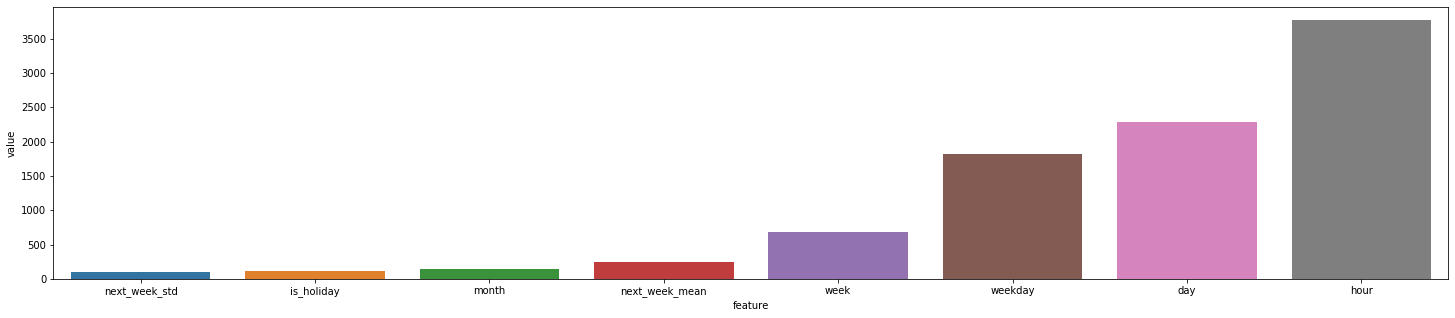

In [26]:
plt.figure(figsize=(25, 5))
sns.barplot(x='feature', y='value', data=pd.DataFrame(sorted(zip(model.feature_importance(), feature)), columns=['value', 'feature']))
plt.show()

- 각각의 경우에 세밀하게 outlier를 선정하는 것을 생각해 보았습니다.
- raw data를 학습하는 것으로써 std, mean, quantile 등의 다양한 통계량을 통해서 비슷한 meter_id를 탐지하고 비슷한 meter_id별로 예측하는 것을 생각해 보았습니다.